In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt


In [5]:
restaurants = gpd.read_file("data/restaurants_with_surplus.geojson")
ngos = gpd.read_file("data/ngos_clustered.geojson")


In [10]:
threshold = restaurants["predicted_surplus"].quantile(0.80)
surplus_restaurants = restaurants[
    restaurants["predicted_surplus"] >= threshold
].copy()


In [11]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius (km)
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))


In [12]:
routes = []

for _, r in restaurants.iterrows():
    for _, n in ngos.iterrows():
        dist = haversine(
            r.geometry.y, r.geometry.x,
            n.geometry.y, n.geometry.x
        )
        routes.append({
            "restaurant": r["name"],
            "ngo": n["name"],   # <-- FIXED
            "distance_km": dist
        })

routes_df = pd.DataFrame(routes)


In [13]:
best_routes = (
    routes_df
    .sort_values("distance_km")
    .groupby("restaurant")
    .first()
    .reset_index()
)


In [14]:
# 1. Clean duplicate columns
for col in ["name", "geometry", "geometry_restaurant", "geometry_ngo"]:
    if col in best_routes.columns:
        best_routes = best_routes.drop(columns=[col])

# 2. Merge restaurant geometry
best_routes = best_routes.merge(
    surplus_restaurants[["name", "geometry"]],
    left_on="restaurant",
    right_on="name"
)
best_routes = best_routes.rename(columns={"geometry": "geometry_restaurant"})
best_routes = best_routes.drop(columns=["name"])

# 3. Merge NGO geometry
best_routes = best_routes.merge(
    ngos[["name", "geometry"]],
    left_on="ngo",
    right_on="name",
)
best_routes = best_routes.rename(columns={"geometry": "geometry_ngo"})
best_routes = best_routes.drop(columns=["name"])


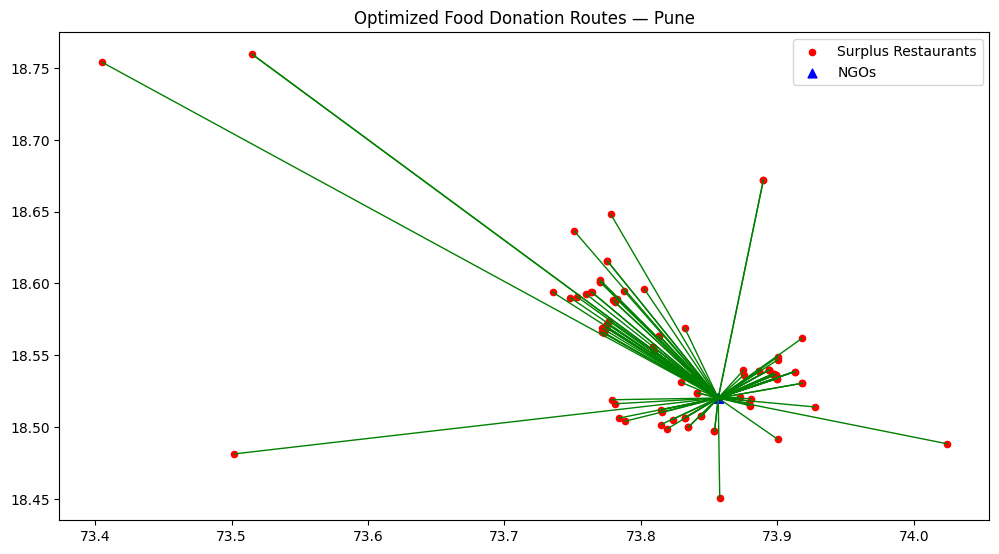

In [15]:
fig, ax = plt.subplots(figsize=(12,12))

surplus_restaurants.plot(ax=ax, color="red", markersize=20, label="Surplus Restaurants")
ngos.plot(ax=ax, color="blue", markersize=40, marker="^", label="NGOs")

for _, row in best_routes.iterrows():
    x = [row.geometry_restaurant.x, row.geometry_ngo.x]
    y = [row.geometry_restaurant.y, row.geometry_ngo.y]
    ax.plot(x, y, color="green", linewidth=1)

plt.legend()
plt.title("Optimized Food Donation Routes — Pune")
plt.show()

In [16]:
print("Total Routes:", len(best_routes))
print("Average Distance (km):", best_routes["distance_km"].mean())
print("Max Distance (km):", best_routes["distance_km"].max())


Total Routes: 101
Average Distance (km): 7.937744442030062
Max Distance (km): 54.23290926101064


In [17]:
co2_saved = best_routes["distance_km"].sum() * 0.21
print("Estimated CO₂ avoided (kg):", round(co2_saved, 2))


Estimated CO₂ avoided (kg): 168.36


In [18]:
best_routes.to_csv("optimized_donation_routes.csv", index=False)


In [19]:
best_routes = gpd.GeoDataFrame(best_routes)


In [20]:
required_cols = ["geometry_restaurant", "geometry_ngo"]

for col in required_cols:
    if col not in best_routes.columns:
        raise ValueError(f"Missing column: {col}")


In [21]:
best_routes["geometry_restaurant"] = gpd.GeoSeries(best_routes["geometry_restaurant"])
best_routes["geometry_ngo"] = gpd.GeoSeries(best_routes["geometry_ngo"])


In [22]:
best_routes["geometry_restaurant_x"] = best_routes["geometry_restaurant"].x
best_routes["geometry_restaurant_y"] = best_routes["geometry_restaurant"].y

best_routes["geometry_ngo_x"] = best_routes["geometry_ngo"].x
best_routes["geometry_ngo_y"] = best_routes["geometry_ngo"].y
